# Paths

In [1]:
from pathlib import Path

fn_initial_design_raw = Path("tmp/meta_learning_bbob/initial_design_raw.csv")
fn_initial_design = Path("tmp/meta_learning_bbob/initial_design.csv")
fn_rollout_data = Path("tmp/meta_learning_bbob/rollout_data.csv")
figoutdir = "./tmp/meta_learning_bbob/figures"

# Data Collection and Conversion

## Collect Rollout Data and Raw Initial Designs

In [ ]:
import pandas as pd
from download_data import add_regret, load_wandb_table, scale_regret
from tqdm import tqdm

# import re


fn_initial_design_raw.parent.mkdir(parents=True, exist_ok=True)
fn_initial_design.parent.mkdir(parents=True, exist_ok=True)
fn_rollout_data.parent.mkdir(parents=True, exist_ok=True)


exp_paths = ["/home/benjamin/Dokumente/code/tmp/DAC-BO/exp_sweep/2022-09-24/21-35-50"]  # budget = 100, 1 instance
exp_paths = [  # budget = 100, 5 instances
    "/home/benjamin/Dokumente/code/tmp/DAC-BO/exp_sweep/2022-09-26/16-12-12",
    "/home/benjamin/Dokumente/code/tmp/DAC-BO/exp_sweep/2022-09-26/16-12-41",
    "/home/benjamin/Dokumente/code/tmp/DAC-BO/exp_sweep/2022-09-29/18-14-55",  # missing dim5,f17,i1,s1-31, budget=200
]


def flatten(l):
    return [item for sublist in l for item in sublist]


# pattern_template = ".*{identifier}.*\\.table\\.json"
def get_paths(exp_paths: list[str]) -> pd.DataFrame:
    paths = [Path(p) for p in exp_paths]
    runpaths = [list(p.rglob("*files/media/table")) for p in paths]
    id_initdesign = "initial_design"
    id_rollout = "rollout_data"
    runpaths = flatten(runpaths)
    data = []
    for p in runpaths:
        fn_id = list(p.rglob("*" + id_initdesign + "*"))[0]
        fn_rd = list(p.rglob("*" + id_rollout + "*"))[0]
        data.append({"runpath": str(p), "initial_design_fn": fn_id, "rollout_data_fn": fn_rd})
    data = pd.DataFrame(data)
    return data


paths = get_paths(exp_paths)

print("Load initial designs")
init_designs = pd.concat(
    [load_wandb_table(table) for table in tqdm(paths["initial_design_fn"], total=len(paths))]
).reset_index(drop=True)
# Drop duplicates because we have n_schedules (7) times the same initial design
init_designs = init_designs.drop_duplicates(subset=["bbob_function", "bbob_instance", "bbob_dimension", "seed"])
print("Load rollout data")
rollout_data = pd.concat(
    [load_wandb_table(table) for table in tqdm(paths["rollout_data_fn"], total=len(paths))]
).reset_index(drop=True)
print("Add regret")
rollout_data = add_regret(rollout_data)
print("Scale regret")
rollout_data = scale_regret(rollout_data)

print(f"Save init design to {fn_initial_design_raw}")
init_designs.to_csv(fn_initial_design_raw, index=False)
print(f"Save rollout data to {fn_rollout_data}")
rollout_data.to_csv(fn_rollout_data, index=False)

In [ ]:
# Sanity check
import pandas as pd

n_schedules = 7
n_seeds = 60
n_instances = 5
n_functions = 24
n_doe = 51
n_points = n_seeds * n_instances * n_functions

doe_raw = pd.read_csv(fn_initial_design_raw)
print(len(doe_raw), n_points)

print("func", doe_raw["bbob_function"].nunique(), doe_raw["bbob_function"].unique())
print("inst", doe_raw["bbob_instance"].nunique(), doe_raw["bbob_instance"].unique())
print("seed", doe_raw["seed"].nunique(), doe_raw["seed"].unique())

doe_raw.columns

## Convert Raw Init Design (Add Fitness)

In [2]:
import pandas as pd
import ioh
import ast
import numpy as np
from tqdm import tqdm
from typing import Any

init_designs = pd.read_csv(fn_initial_design_raw)

n_doe = 51


def add_fitness_to_init_designs(init_designs: pd.DataFrame) -> pd.DataFrame:
    new_df = []
    for index, row in tqdm(init_designs.iterrows(), total=len(init_designs)):
        inst = row["bbob_instance"]
        fid = row["bbob_function"]
        dim = row["bbob_dimension"]
        seed = row["seed"]
        problem = ioh.get_problem(instance=inst, fid=fid, dimension=dim)
        X = row["initial_design"]
        X = np.array(ast.literal_eval(X))
        if len(X) > 51:
             #print(fid, inst, seed, len(X))
            X = X[:n_doe]
        X_str = [np.array2string(x, separator=",") for x in X]
        Y = np.array([problem(x) for x in X])
        optimum = problem.objective.y
        regret = Y - optimum
        n = len(X)

        def tovec(x: Any) -> list[Any]:
            return [x] * n

        df = pd.DataFrame(
            {
                "bbob_function": tovec(fid),
                "bbob_instance": tovec(inst),
                "bbob_dimension": tovec(dim),
                "point_id": np.arange(0, len(X)),
                "search_point": X_str,
                "fitness": Y,
                "optimum": tovec(optimum),
                "regret": regret,
                "seed": tovec(seed),
            }
        )
        new_df.append(df)
    df = pd.concat(new_df).reset_index(drop=True)
    return df


df = add_fitness_to_init_designs(init_designs=init_designs)
df.to_csv(fn_initial_design, index=False)

 45%|████▌     | 3267/7200 [00:13<00:15, 251.72it/s]

23 5 32 52
23 5 33 60
23 5 35 53
23 5 36 54
23 5 37 53
23 5 42 52
23 5 48 52
23 5 50 55
23 5 52 62
23 5 53 56
23 5 54 53
23 5 55 55
23 5 60 53
23 3 37 57
23 3 39 53
23 3 42 53
23 3 43 52
23 3 44 52
23 3 47 55
23 3 48 53
23 3 50 56


 46%|████▋     | 3345/7200 [00:13<00:15, 251.68it/s]

23 3 51 54
23 3 52 52
23 3 55 56
23 3 57 52
23 3 59 52
23 3 60 52
23 4 32 54
23 4 34 54
23 4 37 52
23 4 40 60
23 4 41 53
23 4 42 52
23 4 44 55
23 4 48 57
23 4 49 59
23 4 52 63
23 4 53 56
23 4 54 62
23 4 55 59
23 4 56 52
23 4 58 53
23 4 60 57


 48%|████▊     | 3423/7200 [00:14<00:14, 252.11it/s]

23 2 32 58
23 2 34 52
23 2 35 53
23 2 37 54
23 2 38 52
23 2 40 55
23 2 41 53
23 2 42 52
23 2 45 57
23 2 47 57
23 2 48 52
23 2 49 57
23 2 50 54
23 2 53 60
23 2 55 55
23 2 57 53
23 2 58 54


 49%|████▉     | 3527/7200 [00:14<00:15, 242.88it/s]

23 1 32 58
23 1 34 55
23 1 36 53
23 1 37 54
23 1 39 62
23 1 40 52
23 1 41 52
23 1 42 55
23 1 44 52
23 1 47 52
23 1 50 54
23 1 52 56
23 1 54 52
23 1 56 63
23 1 57 64
23 1 58 54


 96%|█████████▋| 6946/7200 [00:28<00:01, 247.59it/s]

23 1 2 54
23 1 3 52
23 1 5 52
23 1 6 53
23 1 8 52
23 1 10 52
23 1 11 60
23 1 13 53
23 1 14 66
23 1 15 55
23 1 18 53
23 1 20 52
23 1 21 52
23 1 25 52
23 1 26 54
23 1 28 52
23 1 29 52
23 1 30 53
23 1 31 57
23 2 2 52
23 2 4 58
23 2 5 52
23 2 7 52
23 2 8 59
23 2 9 53
23 2 10 56
23 2 12 57
23 2 17 57
23 2 18 52
23 2 19 52
23 2 20 52
23 2 21 57
23 2 22 54
23 2 23 57


 98%|█████████▊| 7024/7200 [00:28<00:00, 248.78it/s]

23 2 26 62
23 2 27 59
23 3 3 53
23 3 11 54
23 3 12 52
23 3 16 52
23 3 18 54
23 3 22 53
23 3 23 52
23 3 24 53
23 3 25 52
23 3 27 52
23 3 30 53
23 4 1 57
23 4 2 55
23 4 4 58
23 4 5 55
23 4 8 52
23 4 11 52
23 4 13 54
23 4 14 57
23 4 16 52
23 4 19 57
23 4 23 52
23 4 24 54
23 4 26 53
23 4 27 54
23 4 28 52
23 5 1 56
23 5 3 56
23 5 5 55
23 5 6 57
23 5 8 63
23 5 9 59
23 5 10 52


 99%|█████████▊| 7102/7200 [00:28<00:00, 251.57it/s]

23 5 12 57
23 5 13 57
23 5 14 52
23 5 15 52
23 5 16 54
23 5 17 53
23 5 18 58
23 5 19 53
23 5 21 59
23 5 22 55
23 5 23 54
23 5 26 65
23 5 27 62
23 5 30 57
23 5 31 54


100%|██████████| 7200/7200 [00:29<00:00, 245.12it/s]


# Plot
## Aggregate

/home/benjamin/.conda/envs/dacbo/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/benjamin/.conda/envs/dacbo/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/benjamin/.conda/envs/dacbo/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/benjamin/.conda/envs/dacbo/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/tmp/ipykernel_29759/1219135803.py:10: FutureWarning: In a fut

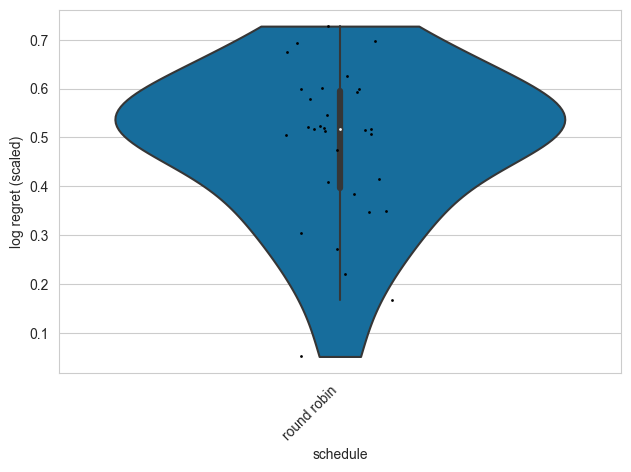

KeyboardInterrupt: 

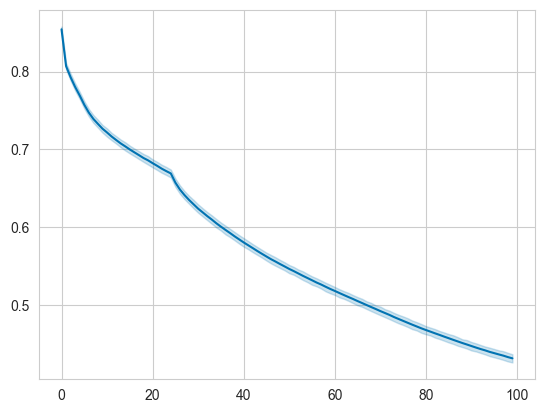

In [3]:
from plot_utils import *
import seaborn as sns
import pandas as pd

df = pd.read_csv(fn_rollout_data)


group_keys = ["bbob_dimension"]  # , "bbob_function"]
groups = df.groupby(by=group_keys)
for group_id, group_df in groups:
    if type(group_id) != list:
        group_id = [group_id]
    if group_id[0] != 5:
        continue
    sns.set_style("whitegrid")
    title = get_group_title(group_keys=group_keys, group_id=group_id)
    # plot_return(data=group_df, title=title)
    # plot_reward_over_steps(data=group_df, title=title)
    plot_final_regret(data=group_df, title=title, yname="regret_log_scaled", outdir=figoutdir)
    plot_regret_over_steps(data=group_df, title=title, yname="regret_log_scaled", errorbar="ci", outdir=figoutdir)

## Per BBOB Function

In [ ]:
from plot_utils import *
import seaborn as sns
import pandas as pd

df = pd.read_csv(fn_rollout_data)
sns.set_style("whitegrid")
sns.set_palette("colorblind")
df.columns
group_keys = ["bbob_dimension", "bbob_function"]
groups = df.groupby(by=group_keys)
for group_id, group_df in groups:
    if type(group_id) != tuple:
        group_id = [group_id]
    if group_id[0] != 5:
        continue
    title = get_group_title(group_keys=group_keys, group_id=group_id)
    # plot_return(data=group_df, title=title)
    # plot_reward_over_steps(data=group_df, title=title)
    plot_final_regret(data=group_df, title=title, yname="regret_log_scaled", outdir=figoutdir)
    plot_regret_over_steps(data=group_df, title=title, yname="regret_log_scaled", errorbar="ci", outdir=figoutdir)

## All Seeds per Schedule

In [ ]:
from plot_utils import *
import seaborn as sns
import pandas as pd

df = pd.read_csv(fn_rollout_data)
data = df[df["bbob_dimension"] == 5]
group_keys = ["bbob_function"]
groups = data.groupby(by=group_keys)
for group_id, group_df in groups:
    if type(group_id) != tuple:
        group_id = [group_id]
    title = get_group_title(group_keys=group_keys, group_id=group_id)
    print(title)
    yname = "regret_log_scaled"
    errorbar = "sd"
    plot_regret_all_samples(data=group_df, title=title, yname=yname, errorbar=errorbar, outdir=figoutdir)